<a href="https://colab.research.google.com/github/UserSaiVarma/TAU-Vehicle-Type-Recognition-Competition/blob/main/Vehicle_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Importing Libraries

In [1]:
import os
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import cv2
from keras_preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras import regularizers, optimizers, initializers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import plot_model

###Getting Data from Kaggle

In [2]:
!curl --header 'Host: storage.googleapis.com' --user-agent 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:95.0) Gecko/20100101 Firefox/95.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --referer 'https://www.kaggle.com/' --header 'DNT: 1' --cookie '_ga=GA1.3.2138036352.1640153352; _gid=GA1.3.1047603770.1640153352' --header 'Upgrade-Insecure-Requests: 1' --header 'Sec-Fetch-Dest: document' --header 'Sec-Fetch-Mode: navigate' --header 'Sec-Fetch-Site: cross-site' --header 'Sec-Fetch-User: ?1' 'https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/17018/799209/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1640486508&Signature=Oldad9UPJqWcxbWxWhLjzmU1hTzXmAGYv%2FtZ3RZvcRqf9EvpKA9voGd9qg%2FAT%2Fjg%2F%2Fb0AcVR9S%2B03NsPivr%2B6fbdurDbBBccKDtJlQ9mHthfQqJnU9D6xrPgf5F41Y%2Fvt1qj%2FdNscdS7MC3PKEDOxuNtzQ8TUEaJ7BqYQxW3jDp4WCFNDZeQjexvub5uJFraj9uCbHX39kJxErbPHwNy8Xq4bBfd5oCaQUR8hDsR4KE8PyPMRTwf09I306%2FISeli7U8CigB1ldWfQPcqYgnQAyLwEa3bzxKaCyS5TtqKasOTf%2F12X1Ic0Ad5YpwWKC7cSwETSMHN7X4SI1r6VkcPiQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dvehicle.zip' --output 'vehicle.zip'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7044M  100 7044M    0     0  48.5M      0  0:02:25  0:02:25 --:--:-- 40.7M


In [3]:
get_ipython().system_raw("unzip vehicle.zip -d vehicle")

In [4]:
!rm vehicle.zip

###Creating dataframe with image paths and corresponding labels

In [5]:
root = 'vehicle/train/train/'
data = []
for category in tqdm(sorted(os.listdir(root))):
    for file in sorted(os.listdir(os.path.join(root, category))):
        data.append((category, os.path.join(root, category,  file)))

df = pd.DataFrame(data, columns=['class', 'file_path'])

100%|██████████| 17/17 [00:00<00:00, 177.62it/s]


In [6]:
print("Total images in the training data are:", len(df))
df.head()

Total images in the training data are: 28045


,class,file_path
0,Ambulance,vehicle/train/train/Ambulance/000040_09.jpg
1,Ambulance,vehicle/train/train/Ambulance/000050_10.jpg
2,Ambulance,vehicle/train/train/Ambulance/000052_03.jpg
3,Ambulance,vehicle/train/train/Ambulance/000057_04.jpg
4,Ambulance,vehicle/train/train/Ambulance/000067_14.jpg


Checking class balance

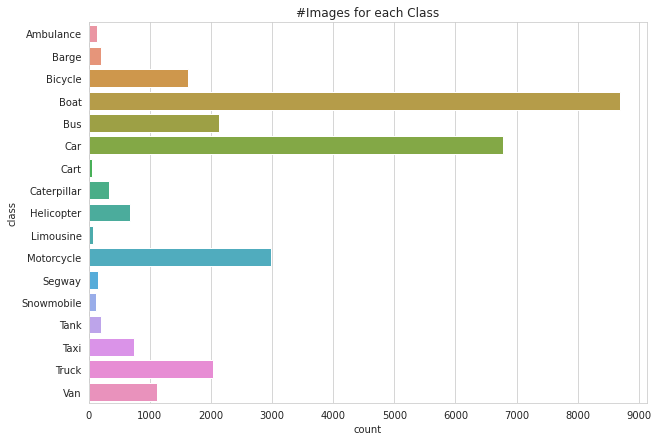

In [7]:
plt.figure(figsize=(10,7))
sns.countplot(y=df['class'])
plt.title("#Images for each Class")
plt.xticks([0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000])
plt.show()

- Data is highly imbalanced

###Checking the shape of images

In [ ]:
##Getting size of images
list_of_heights = []
list_of_widths = []
for path in tqdm(df["file_path"].values):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    # get dimensions of image
    shape = img.shape
    list_of_heights.append(shape[0])
    list_of_widths.append(shape[1]) 

100%|██████████| 28045/28045 [10:24<00:00, 44.94it/s]


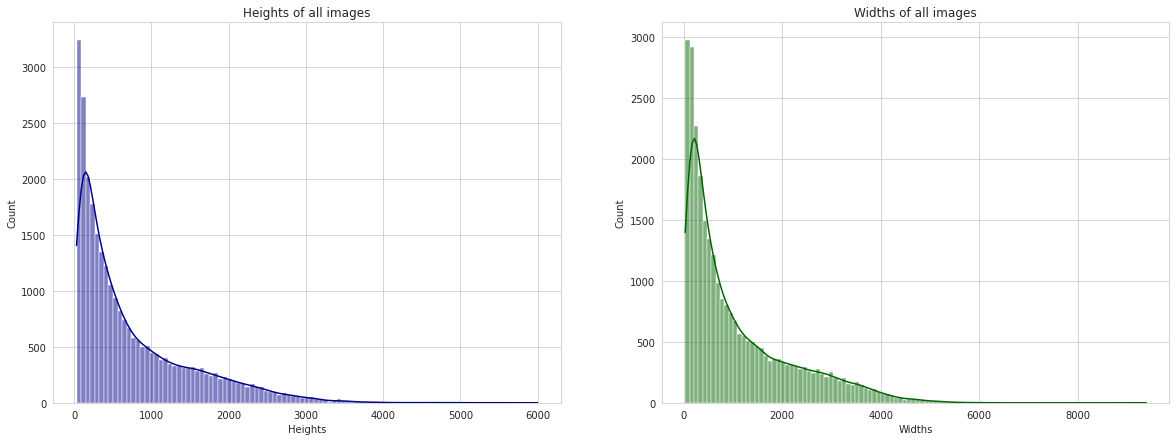

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20,7))

sns.histplot(ax=ax[0], x=list_of_heights, kde=True, color='darkblue')
ax[0].set_title("Heights of all images")
ax[0].set_xlabel("Heights")

sns.histplot(ax=ax[1], x=list_of_widths, kde=True, color='darkgreen')
ax[1].set_title("Widths of all images")
ax[1].set_xlabel("Widths")

plt.show()

- Heights of images are ranged from 200 to 6000 whose mean is centered at 500
- Widths of images are ranges from 200 to 10000 whose mean is centered at 500

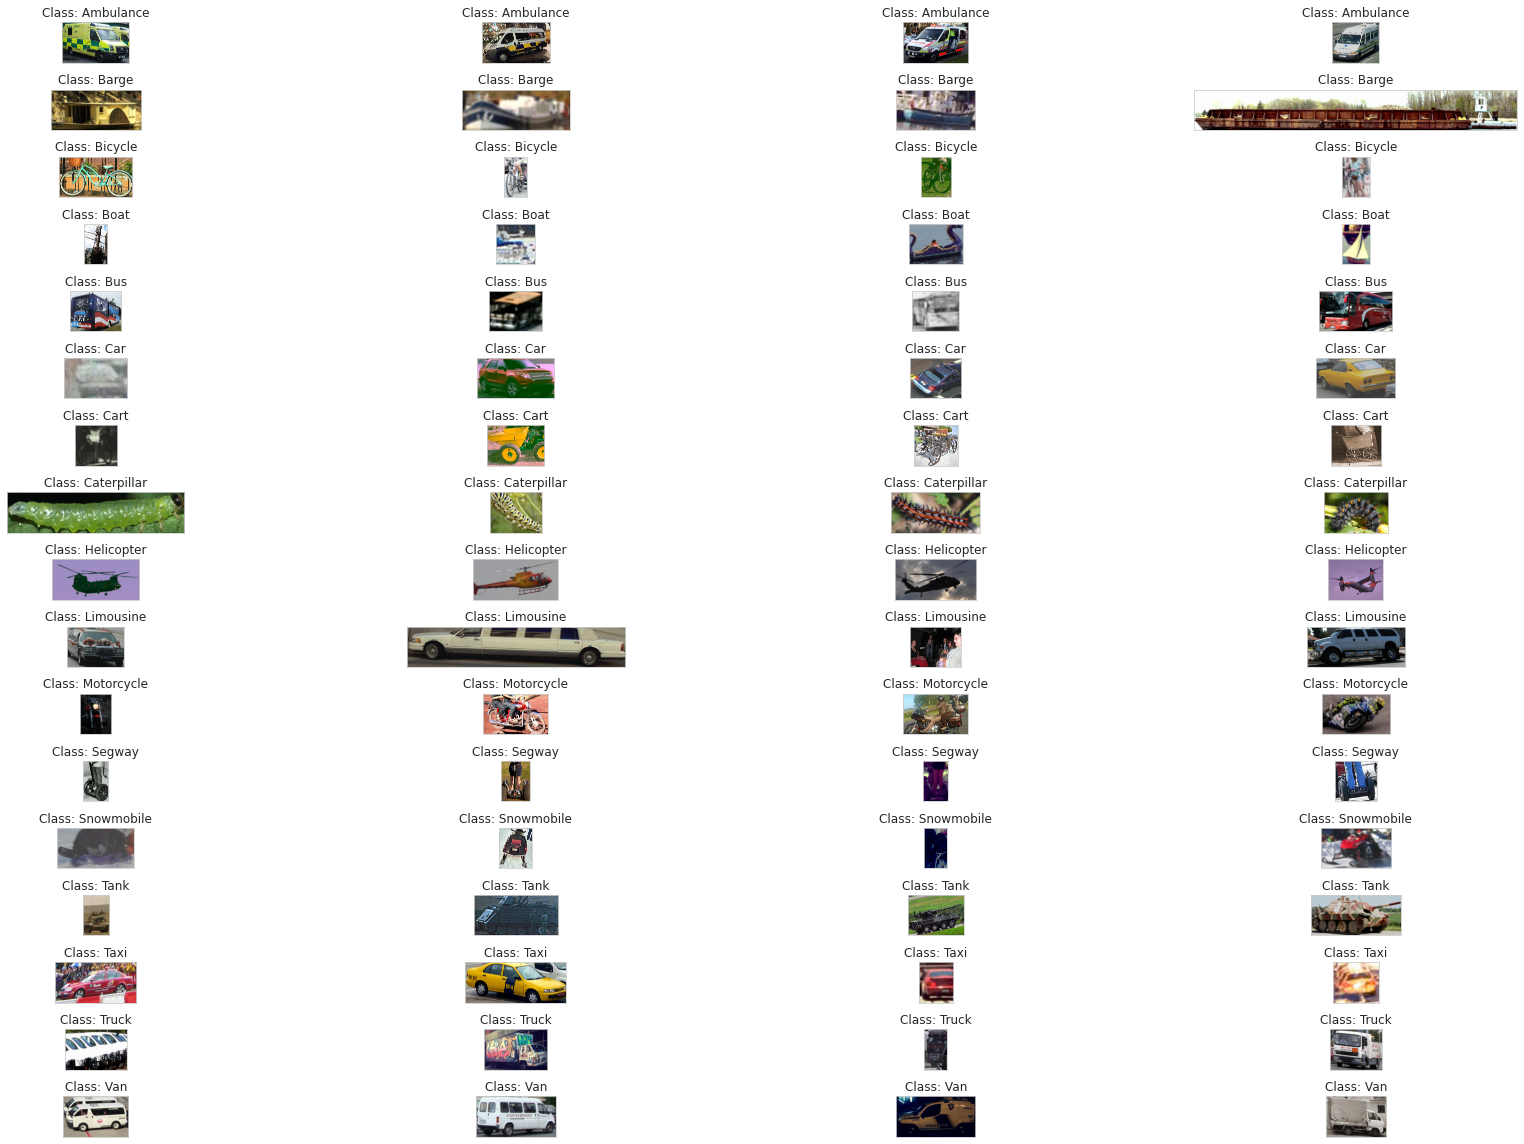

In [ ]:
fig = plt.figure(figsize=(25, 16))
for num, category in enumerate(sorted(df['class'].unique())):
    for i, (idx, row) in enumerate(df.loc[df['class'] == category].sample(4).iterrows()):
        ax = fig.add_subplot(17, 4, num * 4 + i + 1, xticks=[], yticks=[])
        im = Image.open(row['file_path'])
        plt.imshow(im)
        ax.set_title(f'Class: {category}')
fig.tight_layout()
plt.show()

###Splitting the data into Train and Validation

since the data is highly imbalanced we use stratify split to split the data evenly

In [21]:
X_train, X_val, y_train, y_val = train_test_split(df['file_path'].values, df['class'].values, test_size=0.25, stratify=df['class'].values, random_state=42)

In [17]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_validation: ", X_val.shape)
print("y_validation: ", y_val.shape)

X_train:  (21033,)
y_train:  (21033,)
X_validation:  (7012,)
y_validation:  (7012,)


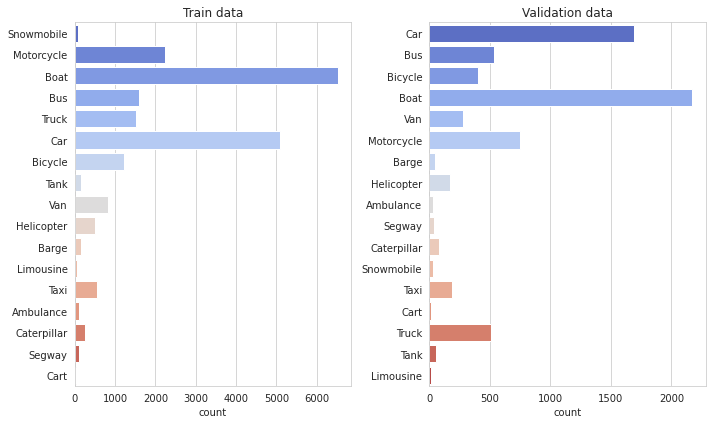

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10,6))
sns.countplot(ax=ax[0], y=y_train, palette='coolwarm')
ax[0].set_title("Train data")
sns.countplot(ax=ax[1], y=y_val, palette='coolwarm')
ax[1].set_title("Validation data")
plt.tight_layout(h_pad=0.5)
plt.show()

In [19]:
column = list(df.columns)
train_df = pd.DataFrame({column[1]:X_train, column[0]:y_train})
print("shape:",train_df.shape)
train_df.head()

shape: (21033, 2)


,file_path,class
0,vehicle/train/train/Snowmobile/000065_07.jpg,Snowmobile
1,vehicle/train/train/Snowmobile/001830_01.jpg,Snowmobile
2,vehicle/train/train/Motorcycle/002816_02.jpg,Motorcycle
3,vehicle/train/train/Boat/000303_08.jpg,Boat
4,vehicle/train/train/Bus/004411_10.jpg,Bus


In [20]:
val_df = pd.DataFrame({column[1]:X_val, column[0]:y_val})
print("shape:",val_df.shape)
val_df.head()

shape: (7012, 2)


,file_path,class
0,vehicle/train/train/Car/003448_00.jpg,Car
1,vehicle/train/train/Bus/002060_03.jpg,Bus
2,vehicle/train/train/Bicycle/001751_01.jpg,Bicycle
3,vehicle/train/train/Boat/004854_10.jpg,Boat
4,vehicle/train/train/Van/000184_04.jpg,Van


Encoding Labels

In [13]:
encoder = LabelEncoder()
encoder.fit(df['class'])

train_df['class'] = encoder.transform(train_df['class'].values)
val_df['class'] = encoder.transform(val_df['class'].values)

In [22]:
print("Train:\n", train_df.head())
print("\n")
print("Validation:\n", val_df.head())

Train:
                                       file_path       class
0  vehicle/train/train/Snowmobile/000065_07.jpg  Snowmobile
1  vehicle/train/train/Snowmobile/001830_01.jpg  Snowmobile
2  vehicle/train/train/Motorcycle/002816_02.jpg  Motorcycle
3        vehicle/train/train/Boat/000303_08.jpg        Boat
4         vehicle/train/train/Bus/004411_10.jpg         Bus


Validation:
                                    file_path    class
0      vehicle/train/train/Car/003448_00.jpg      Car
1      vehicle/train/train/Bus/002060_03.jpg      Bus
2  vehicle/train/train/Bicycle/001751_01.jpg  Bicycle
3     vehicle/train/train/Boat/004854_10.jpg     Boat
4      vehicle/train/train/Van/000184_04.jpg      Van


###Loading data using Image Data Generator

Train data

In [23]:
datagen_train= ImageDataGenerator(rotation_range=10,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.1,
                             zoom_range=0.1,
                             rescale=1./255.)
train_generator=datagen_train.flow_from_dataframe(dataframe=train_df,
                                                  directory=None,
                                                  x_col=column[1],
                                                  y_col=column[0],
                                                  batch_size=256,
                                                  seed=42,
                                                  shuffle=True,
                                                  class_mode="categorical",
                                                  target_size=(300,300))

Found 21033 validated image filenames belonging to 17 classes.


Validation data

In [24]:
datagen_val = ImageDataGenerator(rescale=1./255.)
valid_generator=datagen_val.flow_from_dataframe(dataframe=val_df,
                                            directory=None,
                                            x_col=column[1],
                                            y_col=column[0],
                                            batch_size=128,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="categorical",
                                            target_size=(300,300))

Found 7012 validated image filenames belonging to 17 classes.


###Building the Model

####Callbacks

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler
#Decaying Learning rate using epoch
def changeLearningRate(epoch, lr):
    if (epoch+1)%8==0:
        return lr*0.85
    else:
        return lr
lrschedule = LearningRateScheduler(changeLearningRate, verbose=1)

from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.9, patience=1)

from tensorflow.keras.callbacks import TerminateOnNaN
loss_terminate = TerminateOnNaN()

from tensorflow.keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor='val_accuracy', patience=2)

callbacks = [lrschedule, reduce_lr, loss_terminate, earlystop]

####Architecture

In [ ]:
def getModel():
    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu',
                     kernel_initializer=initializers.he_normal(),
                     kernel_regularizer=regularizers.l2()))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(GlobalMaxPooling2D())
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(16, activation='softmax'))
    optimizer = optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy', metrics=['accuracy'])
    
    STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
    STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

    model.fit_generator(generator=train_generator,steps_per_epoch=STEP_SIZE_TRAIN,
                        validation_data=valid_generator,
                        validation_steps=STEP_SIZE_VALID,
                        epochs=25,
                        callbacks=callbacks)
    
    model.summary()
    plot_model(model, show_shapes=True, to_file='model_1_shape.png')